# Predicting Loan Defaults
> Author: Alex Lau

## Table of Contents

1. [Table of Contents](#1.-Table-of-Contents)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
    <br>2.1 [Import Packages and Data](#2.1-Import-Packages-and-Data)
    <br>2.2 [High Level Checks](#2.2-High-Level-Checks)
    <br>2.3 [Investigating Target Variable](#2.3-Investigating-Target-Variable)
    <br>2.4 [Investigating Features](#2.4-Investigating-Features)
3. [Data Cleaning](#3.-Data-Cleaning)
4. [Revisiting Exploratory Data Analysis: Correlations Deep Dive](#4.-Revisiting-Exploratory-Data-Analysis:-Correlations-Deep-Dive)
5. [Preprocessing](#5.-Preprocessing)
6. [Modeling](#6.-Modeling)
    <br>6.1 [Baseline Model](#6.1-Baseline-Model)
    <br>6.2 [Logistic Regression](#6.2-Logistic-Regression)
    <br>6.3 [Random Forest Classifier](#6.4-Random-Forest-Classifier)
    <br>6.4 [Extra Trees Classifier](#6.5-Extra-Trees-Classifier)
    <br>6.5 [AdaBoost Classifier](#6.6-AdaBoost-Classifier)
    <br>6.6 [Gradient Boost Classifier](#6.6-Gradient-Boost-Classifier)
7. [Conclusions and Evaluation](#7.-Conclusions-and-Evaluation)

## 2. Exploratory Data Analysis

### 2.1 Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


Download data from this website after creating an account
https://www.lendingclub.com/info/statistics.action

Read in main dataframe that we created from the "Downloading Data" notebook.

In [2]:
# Read in the main dataframe we have created after consolidating the downloaded files.
# this results in a mixed type warning, so we will check what these columns are in the next section
df = pd.read_csv('../Data/FullLoanStats.csv')

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (51,146,147,148) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.2 High Level Checks

In [3]:
# checking the first 5 rows of our dataframe
# we will remove the Unnamed columns, but first we will check the warning on mixed type columns since these are indexed
df.head()

,Unnamed: 0,Unnamed: 1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,2019Q1_1,13,149477700,NaN,15000.0,15000.0,15000.0,36 months,17.97%,542.07,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,2019Q1_1,17,149521312,NaN,3025.0,3025.0,3025.0,36 months,17.19%,108.14,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2019Q1_1,54,149416464,NaN,5000.0,5000.0,5000.0,36 months,20.00%,185.82,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,2019Q1_1,56,148453246,NaN,12000.0,12000.0,12000.0,60 months,12.40%,269.37,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,2019Q1_1,65,149484294,NaN,3000.0,3000.0,3000.0,36 months,15.57%,104.84,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


The following columns will be removed for our model, since these are not relevant for predicting a loan default before approving the loan. Deb settlement refers to activity post default. 

In [4]:
# columns 51, 146, 147, 148 have mixed types

# create a list of these columns
mixed_type_columns = [51, 146, 147, 148]

# iterate through this list and print every column name
for column in mixed_type_columns:
    print(list(df.columns)[column])

next_pymnt_d
debt_settlement_flag_date
settlement_status
settlement_date


In [5]:
# Removing unnamed columns
df.drop(columns = ['Unnamed: 0', 'Unnamed: 1'], inplace = True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,149477700,NaN,15000.0,15000.0,15000.0,36 months,17.97%,542.07,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,149521312,NaN,3025.0,3025.0,3025.0,36 months,17.19%,108.14,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,149416464,NaN,5000.0,5000.0,5000.0,36 months,20.00%,185.82,D,D2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,148453246,NaN,12000.0,12000.0,12000.0,60 months,12.40%,269.37,B,B4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,149484294,NaN,3000.0,3000.0,3000.0,36 months,15.57%,104.84,C,C3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Checking number of rows and columns of dataframe
df.shape

(44171, 150)

In [7]:
# removing view limitation so we can see all columns
pd.set_option('display.max_columns', None)

# checking the top 5 rows
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,149477700,NaN,15000.0,15000.0,15000.0,36 months,17.97%,542.07,D,D1,Administrative Assistant,5 years,MORTGAGE,58240.0,Verified,Mar-19,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,907xx,CA,38.53,1.0,Aug-05,660.0,664.0,0.0,8.0,NaN,9.0,0.0,67035.0,66.40%,18.0,w,0.0,0.0,16566.611300,16566.61,15000.0,1566.61,0.0,0.0,0.0,Oct-19,13344.14,NaN,Jan-20,729.0,725.0,0.0,8.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,149521312,NaN,3025.0,3025.0,3025.0,36 months,17.19%,108.14,C,C5,Warehouse employee,3 years,RENT,30000.0,Source Verified,Mar-19,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,300xx,GA,11.88,0.0,Jul-05,665.0,669.0,0.0,27.0,NaN,9.0,0.0,2885.0,43.70%,22.0,w,0.0,0.0,3191.876646,3191.88,3025.0,166.88,0.0,0.0,0.0,Jul-19,2873.24,NaN,Jan-20,649.0,645.0,0.0,82.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,NaN,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,NaN,NaN,NaN,NaN,NaN,NaN

In [8]:
# Checking statistics
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,4.417100e+04,0.0,44171.000000,44171.000000,44171.000000,44171.000000,4.417100e+04,0.0,44061.000000,44171.000000,44171.000000,44171.000000,44171.000000,19140.000000,5647.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,9858.000000,44171.0,5.359000e+03,5359.000000,44171.000000,44171.000000,4.417100e+04,44171.000000,44171.000000,44171.000000,44171.000000,43165.000000,4.417100e+04,37948.000000,44171.000000,44171.000000,44171.000000,44156.000000,4.417100e+04,44171.000000,44171.000000,44171.000000,44171.000000,44167.000000,43499.000000,43467.000000,44171.000000,44171.000000,43165.000000,44171.000000,44171.000000,44171.000000,44171.000000,43526.000000,8925.000000,40624.000000,12837.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,43282.0,44171.000000,44171.000000,44171.000000,44171.000000,43493.000000,44171.000000,44171.0,4.417100e+04,4.417100e+04,4.417100e+04,4.417100e+04,5359.000000,5359.000000,5359.000000,5359.000000,5359.000000,5359.000000,5271.000000,5359.000000,5359.000000,5359.000000,5359.000000,1586.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270.000000,270.000000,270.000000
mean,1.513762e+08,NaN,14709.117973,14709.117973,14705.859312,440.796324,8.668986e+04,NaN,19.325508,0.231306,710.852143,714.852641,0.569220,37.150000,86.296795,11.730026,0.129542,15780.724299,25.111227,1.365678,1.365678,13453.670997,13450.554645,12739.050372,662.022529,0.598221,51.999868,7.631899,10568.141817,702.701569,690.879197,0.015214,46.368635,1.0,1.389062e+05,18.555777,0.000045,160.691698,1.648198e+05,1.107152,2.799597,0.955921,2.032850,16.151975,3.966007e+04,71.779883,1.350932,2.753051,5708.607073,52.185524,4.212331e+04,1.427317,1.897104,2.306287,5.113491,15872.438065,18591.326053,43.035091,0.008128,1.891988,

In [9]:
# checking datatypes, memory usage, 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44171 entries, 0 to 44170
Columns: 150 entries, id to settlement_term
dtypes: float64(119), int64(1), object(30)
memory usage: 50.5+ MB


In [10]:
# setting row view limitation, 150 for the number of columns
pd.set_option("display.max_rows", 150)
# viewing datatypes of each column
df.dtypes

id                                              int64
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

Below are the counts of the null values of our dataset. We will remove all features where all values are the same. This includes where null values = 44171, since that is the shape of our dataframe. We will also remove all data that is collected after the loan is approved, includuing settlement columns mentioned earlier, since we are trying to predict loan defaults from before the loan is approved. This activity will be reviewed in section 2.4

In [11]:
# viewing all columns with null values sorted by count
df.isnull().sum().sort_values(ascending = False)

hardship_reason                               44171
hardship_status                               44171
hardship_amount                               44171
hardship_start_date                           44171
hardship_end_date                             44171
payment_plan_start_date                       44171
hardship_length                               44171
hardship_dpd                                  44171
hardship_loan_status                          44171
orig_projected_additional_accrued_interest    44171
hardship_payoff_balance_amount                44171
hardship_last_payment_amount                  44171
member_id                                     44171
hardship_type                                 44171
desc                                          44171
deferral_term                                 44171
next_pymnt_d                                  44166
settlement_percentage                         43901
settlement_term                               43901
settlement_s

### 2.3 Investigating Target Variable

In [12]:
# getting distribution of target variable
df['loan_status'].value_counts()

Fully Paid     38672
Charged Off     5494
Default            5
Name: loan_status, dtype: int64

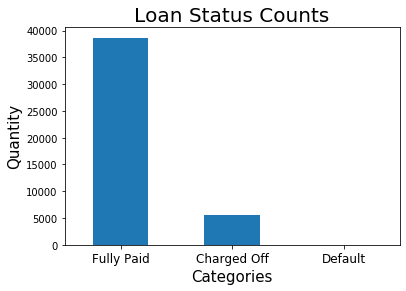

In [13]:
# visualize the quantities
df['loan_status'].value_counts().plot.bar()
plt.title('Loan Status Counts', size = 20)
plt.xlabel('Categories', size = 15)
plt.ylabel('Quantity', size = 15)
plt.xticks(rotation = 0, size = 12);

In [14]:
# getting percentages of each value
df['loan_status'].value_counts(normalize = True)

Fully Paid     0.875507
Charged Off    0.124380
Default        0.000113
Name: loan_status, dtype: float64

Slightly over 12% of our list of loans were defaulted, which represents heavy imbalance and will cause poor model performance. This is expected to be a low percentage, since Lending Club would not approve loans if they thought the borrowers would default. They have also been improving on the fully paid vs charged off or default ratio over the years. 
We will use Smote to help with our unbalanced classes during the preprocessing sections.

The term "Charged off" is when a creditor, Lending Club in this case, gives up hope you will repay the money after months of not paying the mininum payments and writes off the debt. Learn more about it in this article from Marketwatch. 
https://www.marketwatch.com/story/everything-you-need-to-know-about-a-charged-off-debt-2019-08-15

We will convert Fully Paid values to 0 and defaulted/charged off to 1 for our model. 

In [15]:
# investigating the mean values of the numberical features for each target variable group
df.groupby(by = ['loan_status']).mean()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
loan_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Charged Off,1.493045e+08,NaN,16856.152166,16856.152166,16853.760768,510.752060,83802.824057,NaN,20.899416,0.223699,703.052421,707.053695,0.619767,35.552654,87.097561,11.442301,0.129414,16415.638697,22.883873,0.000,0.000,2148.356596,2148.053280,1028.061041,700.034982,2.188841,418.071742,61.359413,518.549392,581.271751,515.373134,0.01711,44.381289,1.0,137120.110196,20.326284,0.000000,187.872588,134878.631962,1.122497,2.609574,0.846560,1.810157,18.305143,36222.704587,71.061415,1.426465,2.866946,5922.890972,54.884559,39545.521296,1.395340,1.662723,2.409902,4.945759,13149.329086,15545.331171,48.881403,0.008009,0.507463,118.422857,166.781034,13.651074,7.663633,1.229523,23.162468,39.436041,6.272599,37.184041,0.437022,3.635420,5.430834,4.959956,7.232253,8.297233,8.271933,13.161267,5.370586,11.420641,0.0,0.000000,0.063888,2.405169,95.202803,33.161001,0.129414,0.0,175421.829086,52874.187841,27110.612304,46129.312523,40816.749674,662.086050,666.086050,0.857888,1.379400,11.177314,57.730872,3.027379,12.504563,0.049544,0.101695,35.110294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8052.634185,51.686593,17.844444
Default,1.494147e+08,NaN,13695.000000,13695.000000,13695.000000,418.186000,55756.800000,NaN,18.350000,0.000000,701.000000,705.000000,0.200000,53.000000,NaN,7.200000,0.000000,6717.200000,19.200000,12064.674,12064.674,2728.632000,2728.632000,1630.326000,1078.260000,20.046000,0.000000,0.000000,442.014000,579.000000,575.000000,0.20000,41.000000,1.0,152000.000000,26.240000,0.000000,3821.000000,61867.000000,0.800000,3.400000,0.800000,1.400000,20.600000,29515.600000,80.500000,0.600000,1.200000,2768.600000,57.200000,16360.000000,1.400000,1.200000,2.000000,2.600000,8411.400000,2356.400000,55.500000,0.000000,0.000000,125.800000,176.200000,24.400000,11.800000,3.000000,56.200000,53.000000,8.250000,53.000000,0.800000,1.600000,2.600000,1.600000,3.40000

### 2.4 Investigating Features

In [16]:
# function for returning the unique values and count, sorted by descending order, based on user specified column
def show_values(column):
    return df[column].value_counts().sort_values(ascending = False)
 
# function for counting null values in a specified column
def null_count(column):
    return df[column].isnull().value_counts().sort_values(ascending = False)

In [17]:
# checking that all id values are unique no repeats
show_values('id')

149028864    1
148398092    1
147855363    1
145694724    1
145696773    1
            ..
146221051    1
163470186    1
148891619    1
158139494    1
147344033    1
Name: id, Length: 44171, dtype: int64

In [18]:
# check distribution of applications
show_values('application_type')

Individual    38812
Joint App      5359
Name: application_type, dtype: int64

We can see that average loans approved for Joint applications are over 19,000 USD, where individuals are 14,000 USD. Joint apps also have a higher joint debt to income ratios at 18.5 vs 17.5 for individuals. 

In [19]:
# checking any visible differences in values of features joint vs individual applications
df.groupby(by = ['application_type']).mean()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
application_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Individual,1.513943e+08,NaN,14072.192878,14072.192878,14068.714229,423.552502,89393.304974,NaN,17.472308,0.233407,709.705375,713.705710,0.585412,37.246858,85.856571,11.817247,0.130424,15580.236628,25.319231,1.289535,1.289535,12897.176798,12893.848774,12221.060099,625.746222,0.510263,49.860202,7.031448,10082.513216,702.258786,690.223642,0.016361,46.326639,1.0,NaN,NaN,0.000052,166.168015,158248.301376,1.124936,2.795527,0.967690,2.052406,15.861083,38942.646166,71.806489,1.382717,2.815186,5672.556220,51.850472,42296.861151,1.443523,1.850974,2.303102,5.183964,15034.739184,18897.504583,42.631221,0.008348,2.153226,124.940092,172.087267,13.691925,7.157503,1.537488,22.972103,40.396141,6.657060,38.175546,0.496006,3.418736,5.049727,5.032696,7.695945,9.586236,8.360378,13.987452,5.006596,11.795476,0.0,0.000026,0.067144,2.494074,95.086870,26.796519,0.130321,0.0,203604.307122,54763.611460,29532.712254,48423.924714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7820.510866,51.580216,17.783550
Joint App,1.512453e+08,NaN,19321.981713,19321.981713,19320.316290,565.682911,67110.448615,NaN,33.028383,0.216085,719.157492,723.159171,0.451950,36.400730,89.651908,11.098339,0.123157,17232.735398,23.604777,1.917134,1.917134,17484.022345,17482.438996,16490.541043,924.749910,1.235247,67.496171,11.980600,14085.256440,705.908378,695.626983,0.006904,46.742714,1.0,138906.195186,18.555777,0.000000,121.030043,212413.292219,0.978354,2.829073,0.870685,1.891211,18.272518,44855.908938,71.580969,1.120731,2.303042,5969.701623,54.613747,40866.421347,1.309946,2.231200,2.329352,4.603098,21940.048339,16337.247020,46.008484,0.006531,0.000000,125.793739,178.029297,16.584064,8.118865,2.028550,28.080661,40.049197,6.861117,37.057479,0.361448,2.924986,4.551409,4.253592,6.555887,8.974436,7.453816,12.444299,4.558313,11.083224,0.0,0.0000

In [20]:
# reporting the percentages of loan statuses based on individual applications
df[df['application_type'] == 'Individual']['loan_status'].value_counts(normalize = True)

Fully Paid     0.878105
Charged Off    0.121792
Default        0.000103
Name: loan_status, dtype: float64

In [21]:
# On average joint applications have higher probability of defaulting or being charged off. 
df[df['application_type'] == 'Joint App']['loan_status'].value_counts(normalize = True)

Fully Paid     0.856690
Charged Off    0.143124
Default        0.000187
Name: loan_status, dtype: float64

We will need to treat individual and joint applications differently, since several features for joint applications are different than individual applications, such as the loan values, incomes, loan repayment rates. 

In [22]:
# creating separate dataframes for individual and joint apps
df_individual = df[df['application_type']=='Individual']
df_JointApp = df[df['application_type']=='Joint App']

# checking individual dataframes
df_individual.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,149477700,NaN,15000.0,15000.0,15000.0,36 months,17.97%,542.07,D,D1,Administrative Assistant,5 years,MORTGAGE,58240.0,Verified,Mar-19,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,907xx,CA,38.53,1.0,Aug-05,660.0,664.0,0.0,8.0,NaN,9.0,0.0,67035.0,66.40%,18.0,w,0.0,0.0,16566.611300,16566.61,15000.0,1566.61,0.0,0.0,0.0,Oct-19,13344.14,NaN,Jan-20,729.0,725.0,0.0,8.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,149521312,NaN,3025.0,3025.0,3025.0,36 months,17.19%,108.14,C,C5,Warehouse employee,3 years,RENT,30000.0,Source Verified,Mar-19,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,300xx,GA,11.88,0.0,Jul-05,665.0,669.0,0.0,27.0,NaN,9.0,0.0,2885.0,43.70%,22.0,w,0.0,0.0,3191.876646,3191.88,3025.0,166.88,0.0,0.0,0.0,Jul-19,2873.24,NaN,Jan-20,649.0,645.0,0.0,82.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,NaN,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,NaN,NaN,NaN,NaN,NaN,NaN

In [23]:
# checking joint dataframe
df_JointApp.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
17,149332442,NaN,7000.0,7000.0,7000.0,36 months,8.81%,221.98,A,A5,Administrative Assistant/Legal Secretary,6 years,MORTGAGE,50000.0,Verified,Mar-19,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,489xx,MI,15.75,0.0,Sep-01,700.0,704.0,0.0,29.0,NaN,12.0,0.0,8559.0,21.40%,33.0,w,0.0,0.0,1103.05000,1103.05,865.56,237.49,0.0,0.0,0.0,Aug-19,221.98,NaN,Jan-20,594.0,590.0,0.0,29.0,1.0,Joint App,72000.0,21.77,Verified,0.0,0.0,33756.0,1.0,1.0,1.0,2.0,12.0,25197.0,86.0,3.0,6.0,7253.0,49.0,40000.0,1.0,5.0,2.0,9.0,2813.0,18951.0,28.2,0.0,0.0,66.0,210.0,3.0,3.0,4.0,3.0,35.0,12.0,35.0,8.0,2.0,5.0,5.0,12.0,6.0,11.0,23.0,5.0,12.0,0.0,0.0,0.0,4.0,72.7,20.0,0.0,0.0,69211.0,33756.0,26400.0,29211.0,22538.0,685.0,689.0,Jan-12,0.0,0.0,14.0,43.9,3.0,17.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
21,149370642,NaN,32000.0,32000.0,32000.0,60 months,20.00%,847.81,D,D2,Police Officer,10+ years,MORTGAGE,69000.0,Source Verified,Mar-19,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,487xx,MI,41.17,0.0,Aug-04,715.0,719.0,0.0,NaN,NaN,15.0,0.0,16822.0,35.50%,36.0,w,0.0,0.0,3320.13000,3320.13,1287.54,2032.59,0.0,0.0,0.0,Aug-19,847.81,NaN,Jan-20,549.0,545.0,0.0,NaN,1.0,Joint App,104000.0,33.54,Source Verified,0.0,0.0,226771.0,3.0,5.0,2.0,4.0,2.0,132161.0,81.0,2.0,3.0,4815.0,59.0,47400.0,1.0,16.0,2.0,7.0,15118.0,26988.0,21.8,0.0,0.0,126.0,175.0,6.0,2.0,1.0,6.0,NaN,12.0,NaN,0.0,3.0,6.0,5.0,9.0,19.0,9.0,16.0,6.0,15.0,0.0,0.0,0.0,4.0,100.0,20.0,0.0,0

In [24]:
# How many emp_titles are there? We will drop this since there are over 18,000 unique values
show_values('emp_title')

Teacher                         698
Manager                         677
Driver                          358
Registered Nurse                291
Supervisor                      237
                               ... 
Design Supervisor                 1
Fuel Coordinator                  1
Community Services Counselor      1
Software Engineer 3               1
Shipping Associate                1
Name: emp_title, Length: 18287, dtype: int64

In [25]:
# checking values within payment plan, perhaps we can drop these since they are all the same
show_values('pymnt_plan')

n    44171
Name: pymnt_plan, dtype: int64

In [26]:
# we confirm there are no null values in payment plan, so we are good to drop
null_count('pymnt_plan')

False    44171
Name: pymnt_plan, dtype: int64

In [27]:
# checking values within feature purpose
show_values('purpose')

debt_consolidation    23766
credit_card            9665
home_improvement       3400
other                  3301
major_purchase         1095
medical                 644
car                     561
house                   557
vacation                449
moving                  367
small_business          338
renewable_energy         28
Name: purpose, dtype: int64

In [28]:
# the count of these values is identical to feature 'purpose' so we will drop one. 
# We will drop title because historical files have null values for in this feature.
show_values('title')

Debt consolidation         23766
Credit card refinancing     9665
Home improvement            3400
Other                       3301
Major purchase              1095
Medical expenses             644
Car financing                561
Home buying                  557
Vacation                     449
Moving and relocation        367
Business                     338
Green loan                    28
Name: title, dtype: int64

In [29]:
# categories of emp length, we can get_dummies, but we'll first need to check null values in the next cell
show_values('emp_length')

10+ years    13916
< 1 year      4695
2 years       3686
3 years       3372
1 year        3008
5 years       2897
4 years       2569
6 years       1912
7 years       1533
8 years       1452
9 years       1043
Name: emp_length, dtype: int64

In [30]:
# checking null counts, we will replace these values with 'Unknown'
null_count('emp_length')

False    40083
True      4088
Name: emp_length, dtype: int64

In [31]:
# counts of values for public records, convert to int
show_values('pub_rec')

0.0    38524
1.0     5584
2.0       55
3.0        6
4.0        1
6.0        1
Name: pub_rec, dtype: int64

In [32]:
# counts of values for public records
show_values('initial_list_status')

w    38932
f     5239
Name: initial_list_status, dtype: int64

In [33]:
# policy codes are all the same values, remove this column
show_values('policy_code')

1.0    44171
Name: policy_code, dtype: int64

In [34]:
# Remove hardship flag, they are all the same values, we will remove this feature since it won't help our model
show_values('hardship_flag')

N    44171
Name: hardship_flag, dtype: int64

In [35]:
# how code the df['loan_status'] values of these debt_settlement_flags?
show_values('debt_settlement_flag')

N    43901
Y      270
Name: debt_settlement_flag, dtype: int64

In [36]:
# revol_bal_joint
show_values('revol_bal_joint')

0.0        5
21849.0    3
17382.0    3
14258.0    3
11978.0    3
          ..
1769.0     1
12275.0    1
40902.0    1
11278.0    1
10459.0    1
Name: revol_bal_joint, Length: 5164, dtype: int64

In [37]:
# what are all of the unique values in the grade feature? We will build a dictionary later to convert these to numbers
show_values('grade')

A    12305
B    12036
C    10736
D     8152
E      926
F       10
G        6
Name: grade, dtype: int64

In [38]:
# Checking unique values for sub_grade, these will also be a dictionary
show_values('sub_grade')

A4    3431
D2    2965
B4    2866
A5    2650
B5    2453
B2    2415
B1    2282
C5    2243
C1    2238
C3    2180
A3    2109
C2    2105
A1    2099
B3    2020
A2    2016
C4    1970
D1    1666
D3    1499
D5    1058
D4     964
E1     346
E5     214
E3     136
E4     125
E2     105
F5       3
F1       3
G1       3
G2       2
F2       2
G3       1
F4       1
F3       1
Name: sub_grade, dtype: int64

In [39]:
# There are no null values in this column within the joint applications. 
# We are safe to impute 0 for the null values in this column for the larger dataframe for individual applications
df_JointApp['revol_bal_joint'].isnull().value_counts().sort_values(ascending = False)

False    5359
Name: revol_bal_joint, dtype: int64

In [40]:
# 38812 null values refer to the individual applications
null_count('revol_bal_joint')

True     38812
False     5359
Name: revol_bal_joint, dtype: int64

In [41]:
# We can also impute 0 for individual accounts for these values as well.
df_JointApp['sec_app_fico_range_low'].isnull().value_counts().sort_values(ascending = False)

False    5359
Name: sec_app_fico_range_low, dtype: int64

In [42]:
# viewing null values for this column on the larger dataframe
null_count('sec_app_fico_range_low')

True     38812
False     5359
Name: sec_app_fico_range_low, dtype: int64

In [43]:
# We can also impute 0 for individual accounts for these values as well.
df_JointApp['sec_app_earliest_cr_line'].isnull().value_counts().sort_values(ascending = False)

False    5359
Name: sec_app_earliest_cr_line, dtype: int64

In [44]:
# viewing null values for this column on the larger dataframe
null_count('sec_app_earliest_cr_line')

True     38812
False     5359
Name: sec_app_earliest_cr_line, dtype: int64

In [45]:
# We can also impute 0 for individual accounts for these values as well.
df_JointApp['annual_inc_joint'].isnull().value_counts().sort_values(ascending = False)

False    5359
Name: annual_inc_joint, dtype: int64

In [46]:
# viewing null values for this column on the larger dataframe
null_count('annual_inc_joint')

True     38812
False     5359
Name: annual_inc_joint, dtype: int64

In [47]:
# We can also impute 0 for individual accounts for these values as well.
df_JointApp['dti_joint'].isnull().value_counts().sort_values(ascending = False)

False    5359
Name: dti_joint, dtype: int64

In [48]:
# viewing null values for this column on the larger dataframe
null_count('dti_joint')

True     38812
False     5359
Name: dti_joint, dtype: int64

In [49]:
# checking the values in verification_status_joint column
show_values('verification_status_joint')

Not Verified       2364
Source Verified    1525
Verified           1026
Name: verification_status_joint, dtype: int64

In [50]:
# There are over 444 null values for verification statuses on joint applications. We will impute "Unknown" for these. 
df_JointApp['verification_status_joint'].isnull().value_counts().sort_values(ascending = False)

False    4915
True      444
Name: verification_status_joint, dtype: int64

In [51]:
# We will impute "N/A" for these values in individual accounts
df_individual['verification_status_joint'].isnull().value_counts().sort_values(ascending = False)

True    38812
Name: verification_status_joint, dtype: int64

In [52]:
# num_tl_120dpd_2m seems unhelpful
show_values('num_tl_120dpd_2m')

0.0    43282
Name: num_tl_120dpd_2m, dtype: int64

In [53]:
# null count for this feature
null_count('num_tl_120dpd_2m')

False    43282
True       889
Name: num_tl_120dpd_2m, dtype: int64

In [54]:
# checking data types for percentages, all values in interest rates are strings
df[df['int_rate'].map(type) != str].shape

(0, 150)

In [55]:
# unfortunately not all values in revolving utilization are strings, they are a mix of strings and ints
df[df['revol_util'].map(type) != str].shape

(79, 150)

In [56]:
# checking the values in question in revolving utilization column. We need to convert this column into the same type
df[df['revol_util'].map(type) != str]['revol_util']

2643     NaN
3568     NaN
3819     NaN
3899     NaN
4937     NaN
5365     NaN
5984     NaN
6293     NaN
6646     NaN
6731     NaN
7377     NaN
7657     NaN
8785     NaN
9069     NaN
9597     NaN
10124    NaN
14033    NaN
15388    NaN
16259    NaN
16582    NaN
16588    NaN
16831    NaN
17819    NaN
17885    NaN
18250    NaN
18787    NaN
19300    NaN
20598    NaN
20625    NaN
20850    NaN
21292    NaN
22641    NaN
23421    NaN
23817    NaN
24462    NaN
24785    NaN
24817    NaN
25408    NaN
25913    NaN
26382    NaN
26732    NaN
27303    NaN
27494    NaN
28484    NaN
28696    NaN
28892    NaN
29695    NaN
30168    NaN
30815    NaN
31261    NaN
32143    NaN
32288    NaN
32321    NaN
32435    NaN
32617    NaN
33048    NaN
35096    NaN
35378    NaN
35628    NaN
36048    NaN
36064    NaN
36216    NaN
36331    NaN
36571    NaN
37809    NaN
38111    NaN
38582    NaN
38703    NaN
39007    NaN
39008    NaN
39430    NaN
39524    NaN
41791    NaN
42095    NaN
42896    NaN
43213    NaN
43286    NaN

Get a correlation chart at some point, either before or after cleaning.

## 3. Data Cleaning

### Updating Target Variable

In [57]:
# dictionary for Y target variable
loan_status_dict = {'Fully Paid':0, 'Charged Off':1, 'Default':1}

df['loan_status'].replace(loan_status_dict, inplace = True)

### Removing unnecessary features for our model

In [58]:
# creating list of columns to remove
remove_cols = ['member_id', 'funded_amnt', 'emp_title', 'issue_d', 'pymnt_plan', 'url', 'desc', 'title', 
               'zip_code', 'earliest_cr_line', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
               'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
               'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 
               'last_fico_range_low', 'policy_code', 'sec_app_earliest_cr_line', 'num_tl_120dpd_2m', 
               'hardship_payoff_balance_amount', 'hardship_type', 'payment_plan_start_date', 'hardship_length', 
               'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_amount',
               'hardship_last_payment_amount', 'deferral_term', 'hardship_start_date', 'hardship_reason', 
               'hardship_status', 'hardship_end_date', 'settlement_term', 'settlement_percentage', 'settlement_amount',
               'settlement_date', 'settlement_status', 'debt_settlement_flag_date', 'hardship_flag', 
               'debt_settlement_flag']

# removing the unnecessary columns
df.drop(columns = remove_cols, inplace = True)

# viewing the new shape
df.shape

(44171, 100)

### Create columns for conditional features where necessary

In [59]:
# list of columns we want to create conditional columns to represent whether a value is populated
# Later we will replace null values in the original columns, so having this extra conditional column will help the model
conditional_columns = ['sec_app_mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog',
                       'mths_since_recent_revol_delinq', 'mths_since_last_delinq', 'il_util', 'mths_since_recent_inq',
                       'mo_sin_old_il_acct', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 'mths_since_recent_bc',
                       'revol_util', 'all_util', 'avg_cur_bal', 'sec_app_revol_util'] 

# function to create new columns
def create_conditionals(df, columns):
    
    # iterate through the list of columns
    for column in columns:
        
        # creating a new column name
        new_name = column + '_conditional'
        
        # values are tranformed into 0 is null, 1 if there is a value
        df[new_name] = df[column].isnull().map({False:1, True: 0})
        
    return df

# calling this function now
create_conditionals(df, conditional_columns)

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog_conditional,mths_since_recent_bc_dlq_conditional,mths_since_last_major_derog_conditional,mths_since_recent_revol_delinq_conditional,mths_since_last_delinq_conditional,il_util_conditional,mths_since_recent_inq_conditional,mo_sin_old_il_acct_conditional,bc_util_conditional,percent_bc_gt_75_conditional,bc_open_to_buy_conditional,mths_since_recent_bc_conditional,revol_util_conditional,all_util_conditional,avg_cur_bal_conditional,sec_app_revol_util_conditional
0,149477700,15000.0,15000.0,36 months,17.97%,542.07,D,D1,5 years,MORTGAGE,58240.0,Verified,0,debt_consolidation,CA,38.53,1.0,660.0,664.0,0.0,8.0,NaN,9.0,0.0,67035.0,66.40%,18.0,w,0.0,8.0,Individual,NaN,NaN,NaN,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,149521312,3025.0,3025.0,36 months,17.19%,108.14,C,C5,3 years,RENT,30000.0,Source Verified,0,debt_consolidation,GA,11.88,0.0,665.0,669.0,0.0,27.0,NaN,9.0,0.0,2885.0,43.70%,22.0,w,0.0,82.0,Individual,NaN,NaN,NaN,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,NaN,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2,149416464,5000.0,5000.0,36 months,20.00%,185.82,D,D2,< 1 year,RENT,42000.0,Not Verified,0,other,NY,6.46,4.0,665.0,669.0,0.0,21.0,NaN,4.0,0.0,1719.0,68.80%,8.0,w,0.0,21.0,Individual,NaN,NaN,NaN,0.0,0.0,1719.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,618.0,69.0,2500.0,0.0,0.0,0.0,0.0,430.0,781.0,68.8,0.0,0.0,NaN,143.0,27.0,27.0,0.0,27.0,21.0,NaN,21.0,0.0,4.0,4.0,4.0,7.0,0.0,4.0,7.0,4.0,4.0,0.0,3.0,0.0,50.0,25.0,0.0,0.0,2500.0,1719.0,2500.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0
3,148453246,12000.0,12000.0,60 months,12.40%,269.37,B,B4,< 1 year,OWN,89000.0,Not Verified,0,home_improvement,OK,17.00,0.0,730.0,734.0,4.0,NaN,105.0,11.0,1.0,8977.0,25.60%,21.0,f,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,66081.0,0.0,7.0,1.0,1.0,11.0,57104.0,57.0,1.0,1.0,5154.0,40.0,35000.

In [60]:
# checking the new number of columns
df.shape

(44171, 116)

### Impute Null values

In [61]:
# lists of columns that we will fill in null values for 
individual_null_to_NA = ['verification_status_joint']
joint_null_to_unknown = ['verification_status_joint']

null_to_unknown = ['emp_length']
null_to_zero = ['sec_app_mths_since_last_major_derog', 'annual_inc_joint', 'revol_bal_joint', 
                     'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_mort_acc', 'sec_app_inq_last_6mths',
                    'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
                    'sec_app_collections_12_mths_ex_med', 'dti_joint', 'mths_since_last_record', 'mths_since_recent_bc_dlq',
                    'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'mths_since_last_delinq', 'il_util', 
                    'mths_since_recent_inq', 'mo_sin_old_il_acct', 'mths_since_rcnt_il', 'bc_util', 'percent_bc_gt_75', 
                    'bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'all_util', 'avg_cur_bal', 'sec_app_revol_util']
null_to_max = ['dti']

# function to fill in the missing values
def replace_null(df, columns, value):
    for column in columns:
        df[column].fillna(value, inplace = True)
    return df

# calling replace null function on the list of columns we will convert to unknown
replace_null(df, null_to_unknown, 'Unknown')

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog_conditional,mths_since_recent_bc_dlq_conditional,mths_since_last_major_derog_conditional,mths_since_recent_revol_delinq_conditional,mths_since_last_delinq_conditional,il_util_conditional,mths_since_recent_inq_conditional,mo_sin_old_il_acct_conditional,bc_util_conditional,percent_bc_gt_75_conditional,bc_open_to_buy_conditional,mths_since_recent_bc_conditional,revol_util_conditional,all_util_conditional,avg_cur_bal_conditional,sec_app_revol_util_conditional
0,149477700,15000.0,15000.0,36 months,17.97%,542.07,D,D1,5 years,MORTGAGE,58240.0,Verified,0,debt_consolidation,CA,38.53,1.0,660.0,664.0,0.0,8.0,NaN,9.0,0.0,67035.0,66.40%,18.0,w,0.0,8.0,Individual,NaN,NaN,NaN,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,149521312,3025.0,3025.0,36 months,17.19%,108.14,C,C5,3 years,RENT,30000.0,Source Verified,0,debt_consolidation,GA,11.88,0.0,665.0,669.0,0.0,27.0,NaN,9.0,0.0,2885.0,43.70%,22.0,w,0.0,82.0,Individual,NaN,NaN,NaN,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,NaN,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2,149416464,5000.0,5000.0,36 months,20.00%,185.82,D,D2,< 1 year,RENT,42000.0,Not Verified,0,other,NY,6.46,4.0,665.0,669.0,0.0,21.0,NaN,4.0,0.0,1719.0,68.80%,8.0,w,0.0,21.0,Individual,NaN,NaN,NaN,0.0,0.0,1719.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,618.0,69.0,2500.0,0.0,0.0,0.0,0.0,430.0,781.0,68.8,0.0,0.0,NaN,143.0,27.0,27.0,0.0,27.0,21.0,NaN,21.0,0.0,4.0,4.0,4.0,7.0,0.0,4.0,7.0,4.0,4.0,0.0,3.0,0.0,50.0,25.0,0.0,0.0,2500.0,1719.0,2500.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0
3,148453246,12000.0,12000.0,60 months,12.40%,269.37,B,B4,< 1 year,OWN,89000.0,Not Verified,0,home_improvement,OK,17.00,0.0,730.0,734.0,4.0,NaN,105.0,11.0,1.0,8977.0,25.60%,21.0,f,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,66081.0,0.0,7.0,1.0,1.0,11.0,57104.0,57.0,1.0,1.0,5154.0,40.0,35000.

In [62]:
# testing, this works! 
show_values('emp_length')

10+ years    13916
< 1 year      4695
Unknown       4088
2 years       3686
3 years       3372
1 year        3008
5 years       2897
4 years       2569
6 years       1912
7 years       1533
8 years       1452
9 years       1043
Name: emp_length, dtype: int64

In [63]:
# replacing null values for columns in null_to_zero list
replace_null(df, null_to_zero, 0)

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog_conditional,mths_since_recent_bc_dlq_conditional,mths_since_last_major_derog_conditional,mths_since_recent_revol_delinq_conditional,mths_since_last_delinq_conditional,il_util_conditional,mths_since_recent_inq_conditional,mo_sin_old_il_acct_conditional,bc_util_conditional,percent_bc_gt_75_conditional,bc_open_to_buy_conditional,mths_since_recent_bc_conditional,revol_util_conditional,all_util_conditional,avg_cur_bal_conditional,sec_app_revol_util_conditional
0,149477700,15000.0,15000.0,36 months,17.97%,542.07,D,D1,5 years,MORTGAGE,58240.0,Verified,0,debt_consolidation,CA,38.53,1.0,660.0,664.0,0.0,8.0,0.0,9.0,0.0,67035.0,66.40%,18.0,w,0.0,8.0,Individual,0.0,0.00,NaN,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,149521312,3025.0,3025.0,36 months,17.19%,108.14,C,C5,3 years,RENT,30000.0,Source Verified,0,debt_consolidation,GA,11.88,0.0,665.0,669.0,0.0,27.0,0.0,9.0,0.0,2885.0,43.70%,22.0,w,0.0,82.0,Individual,0.0,0.00,NaN,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,0.0,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2,149416464,5000.0,5000.0,36 months,20.00%,185.82,D,D2,< 1 year,RENT,42000.0,Not Verified,0,other,NY,6.46,4.0,665.0,669.0,0.0,21.0,0.0,4.0,0.0,1719.0,68.80%,8.0,w,0.0,21.0,Individual,0.0,0.00,NaN,0.0,0.0,1719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,618.0,69.0,2500.0,0.0,0.0,0.0,0.0,430.0,781.0,68.8,0.0,0.0,0.0,143.0,27.0,27.0,0.0,27.0,21.0,0.0,21.0,0.0,4.0,4.0,4.0,7.0,0.0,4.0,7.0,4.0,4.0,0.0,3.0,0.0,50.0,25.0,0.0,0.0,2500.0,1719.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0
3,148453246,12000.0,12000.0,60 months,12.40%,269.37,B,B4,< 1 year,OWN,89000.0,Not Verified,0,home_improvement,OK,17.00,0.0,730.0,734.0,4.0,0.0,105.0,11.0,1.0,8977.0,25.60%,21.0,f,0.0,0.0,Individual,0.0,0.00,NaN,0.0,0.0,66081.0,0.0,7.0,1.0,1.0,11.0,57104.0,57.0,1.0,1.0,5154.0,40.0,35

In [64]:
# replacing null values in column dti (debt to income) with max value, which we know is 999
replace_null(df, null_to_max, 999) # we already know the max value is 999 from the describe function during EDA

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog_conditional,mths_since_recent_bc_dlq_conditional,mths_since_last_major_derog_conditional,mths_since_recent_revol_delinq_conditional,mths_since_last_delinq_conditional,il_util_conditional,mths_since_recent_inq_conditional,mo_sin_old_il_acct_conditional,bc_util_conditional,percent_bc_gt_75_conditional,bc_open_to_buy_conditional,mths_since_recent_bc_conditional,revol_util_conditional,all_util_conditional,avg_cur_bal_conditional,sec_app_revol_util_conditional
0,149477700,15000.0,15000.0,36 months,17.97%,542.07,D,D1,5 years,MORTGAGE,58240.0,Verified,0,debt_consolidation,CA,38.53,1.0,660.0,664.0,0.0,8.0,0.0,9.0,0.0,67035.0,66.40%,18.0,w,0.0,8.0,Individual,0.0,0.00,NaN,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,149521312,3025.0,3025.0,36 months,17.19%,108.14,C,C5,3 years,RENT,30000.0,Source Verified,0,debt_consolidation,GA,11.88,0.0,665.0,669.0,0.0,27.0,0.0,9.0,0.0,2885.0,43.70%,22.0,w,0.0,82.0,Individual,0.0,0.00,NaN,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,0.0,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2,149416464,5000.0,5000.0,36 months,20.00%,185.82,D,D2,< 1 year,RENT,42000.0,Not Verified,0,other,NY,6.46,4.0,665.0,669.0,0.0,21.0,0.0,4.0,0.0,1719.0,68.80%,8.0,w,0.0,21.0,Individual,0.0,0.00,NaN,0.0,0.0,1719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,618.0,69.0,2500.0,0.0,0.0,0.0,0.0,430.0,781.0,68.8,0.0,0.0,0.0,143.0,27.0,27.0,0.0,27.0,21.0,0.0,21.0,0.0,4.0,4.0,4.0,7.0,0.0,4.0,7.0,4.0,4.0,0.0,3.0,0.0,50.0,25.0,0.0,0.0,2500.0,1719.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0
3,148453246,12000.0,12000.0,60 months,12.40%,269.37,B,B4,< 1 year,OWN,89000.0,Not Verified,0,home_improvement,OK,17.00,0.0,730.0,734.0,4.0,0.0,105.0,11.0,1.0,8977.0,25.60%,21.0,f,0.0,0.0,Individual,0.0,0.00,NaN,0.0,0.0,66081.0,0.0,7.0,1.0,1.0,11.0,57104.0,57.0,1.0,1.0,5154.0,40.0,35

In [65]:
# There are 39256 null values for verification status joint
null_count('verification_status_joint')

True     39256
False     4915
Name: verification_status_joint, dtype: int64

In [66]:
# 38812 of these values are associated to individual applications
df.loc[df.application_type =='Individual','verification_status_joint'].isnull().sum()

38812

In [67]:
# The remaining 444 null values are associated to Joint applications
df.loc[df.application_type =='Joint App','verification_status_joint'].isnull().sum()

444

In [68]:
# We will now update verification status joint features for individual applications from null to "Not Applicable"
df.loc[df.application_type=='Individual','verification_status_joint'] = df.loc[df.application_type =='Individual','verification_status_joint'].fillna('Not Applicable')

In [69]:
# We will now update verification status joint values for joint applications from null to "Unknown"
df.loc[df.application_type =='Joint App','verification_status_joint'] = df.loc[df.application_type =='Joint App','verification_status_joint'].fillna('Unknown')

In [70]:
# checking null count for this feature, there should no longer be null values in this column
null_count('verification_status_joint')

False    44171
Name: verification_status_joint, dtype: int64

In [71]:
# Checking if we have any null values for all features, we do not
df.isnull().sum().sort_values(ascending = False)

sec_app_revol_util_conditional                     0
total_bal_il                                       0
application_type                                   0
annual_inc_joint                                   0
dti_joint                                          0
verification_status_joint                          0
acc_now_delinq                                     0
tot_coll_amt                                       0
tot_cur_bal                                        0
open_acc_6m                                        0
open_act_il                                        0
open_il_12m                                        0
open_il_24m                                        0
mths_since_rcnt_il                                 0
il_util                                            0
avg_cur_bal_conditional                            0
open_rv_12m                                        0
open_rv_24m                                        0
max_bal_bc                                    

### Converting Strings into Numbers

Ordinal values

In [72]:
# creating dictionaries for ordinal values
grade_dict = {'A': 1,'B': 2,'C': 3,'D': 4, 'E':5, 'F': 6, 'G':7}
sub_grade_dict = {'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 
                  'B1':6, 'B2':7, 'B3':8, 'B4':9, 'B5':10,
                  'C1':11, 'C2':12, 'C3':13, 'C4':14, 'C5':15,
                  'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20,
                  'E1':21, 'E2':22, 'E3':23, 'E4':24, 'E5':25, 
                  'F1':26, 'F2':27, 'F3':28, 'F4':29, 'F5':30, 
                  'G1':31, 'G2':32, 'G3':33, 'G4':34, 'G5':35}

In [73]:
# replacing the values from the dictionary
df['grade'].replace(grade_dict, inplace = True)
df['sub_grade'].replace(sub_grade_dict, inplace = True)

In [74]:
# checking the changes
df.head()

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog_conditional,mths_since_recent_bc_dlq_conditional,mths_since_last_major_derog_conditional,mths_since_recent_revol_delinq_conditional,mths_since_last_delinq_conditional,il_util_conditional,mths_since_recent_inq_conditional,mo_sin_old_il_acct_conditional,bc_util_conditional,percent_bc_gt_75_conditional,bc_open_to_buy_conditional,mths_since_recent_bc_conditional,revol_util_conditional,all_util_conditional,avg_cur_bal_conditional,sec_app_revol_util_conditional
0,149477700,15000.0,15000.0,36 months,17.97%,542.07,4,16,5 years,MORTGAGE,58240.0,Verified,0,debt_consolidation,CA,38.53,1.0,660.0,664.0,0.0,8.0,0.0,9.0,0.0,67035.0,66.40%,18.0,w,0.0,8.0,Individual,0.0,0.0,Not Applicable,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,149521312,3025.0,3025.0,36 months,17.19%,108.14,3,15,3 years,RENT,30000.0,Source Verified,0,debt_consolidation,GA,11.88,0.0,665.0,669.0,0.0,27.0,0.0,9.0,0.0,2885.0,43.70%,22.0,w,0.0,82.0,Individual,0.0,0.0,Not Applicable,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,0.0,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2,149416464,5000.0,5000.0,36 months,20.00%,185.82,4,17,< 1 year,RENT,42000.0,Not Verified,0,other,NY,6.46,4.0,665.0,669.0,0.0,21.0,0.0,4.0,0.0,1719.0,68.80%,8.0,w,0.0,21.0,Individual,0.0,0.0,Not Applicable,0.0,0.0,1719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,618.0,69.0,2500.0,0.0,0.0,0.0,0.0,430.0,781.0,68.8,0.0,0.0,0.0,143.0,27.0,27.0,0.0,27.0,21.0,0.0,21.0,0.0,4.0,4.0,4.0,7.0,0.0,4.0,7.0,4.0,4.0,0.0,3.0,0.0,50.0,25.0,0.0,0.0,2500.0,1719.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0
3,148453246,12000.0,12000.0,60 months,12.40%,269.37,2,9,< 1 year,OWN,89000.0,Not Verified,0,home_improvement,OK,17.00,0.0,730.0,734.0,4.0,0.0,105.0,11.0,1.0,8977.0,25.60%,21.0,f,0.0,0.0,Individual,0.0,0.0,Not Applicable,0.0,0.0,66081.0,0.0,7.0,1.0,1.0,1

### Converting Perecentages to Numbers

In [75]:
# first we need to convert column 'revol_util' into strings since this had mixed data types
df['revol_util'] = df['revol_util'].astype(str)

In [76]:
# creating a list of columns that have %s
percent_list = ['int_rate', 'revol_util']

# creating function to strip the % from each row of the specified columns, and then convert the values to float type
def convert_percent_to_num(df, columns):
    for column in columns:
        df[column] = df[column].map(lambda x: x.rstrip('%'))
        # convert the string to float
        df[column] = df[column].astype('float64')
    return df

convert_percent_to_num(df, percent_list)

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog_conditional,mths_since_recent_bc_dlq_conditional,mths_since_last_major_derog_conditional,mths_since_recent_revol_delinq_conditional,mths_since_last_delinq_conditional,il_util_conditional,mths_since_recent_inq_conditional,mo_sin_old_il_acct_conditional,bc_util_conditional,percent_bc_gt_75_conditional,bc_open_to_buy_conditional,mths_since_recent_bc_conditional,revol_util_conditional,all_util_conditional,avg_cur_bal_conditional,sec_app_revol_util_conditional
0,149477700,15000.0,15000.0,36 months,17.97,542.07,4,16,5 years,MORTGAGE,58240.0,Verified,0,debt_consolidation,CA,38.53,1.0,660.0,664.0,0.0,8.0,0.0,9.0,0.0,67035.0,66.4,18.0,w,0.0,8.0,Individual,0.0,0.00,Not Applicable,0.0,0.0,271606.0,0.0,2.0,1.0,3.0,7.0,34645.0,88.0,1.0,3.0,13753.0,78.0,116700.0,4.0,2.0,2.0,6.0,30178.0,12317.0,66.4,0.0,0.0,163.0,157.0,10.0,7.0,1.0,10.0,24.0,7.0,24.0,1.0,5.0,6.0,5.0,6.0,7.0,6.0,10.0,6.0,9.0,0.0,1.0,2.0,88.9,20.0,0.0,0.0,336009.0,101680.0,36700.0,39309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,149521312,3025.0,3025.0,36 months,17.19,108.14,3,15,3 years,RENT,30000.0,Source Verified,0,debt_consolidation,GA,11.88,0.0,665.0,669.0,0.0,27.0,0.0,9.0,0.0,2885.0,43.7,22.0,w,0.0,82.0,Individual,0.0,0.00,Not Applicable,0.0,0.0,19021.0,0.0,3.0,0.0,1.0,16.0,16136.0,82.0,3.0,4.0,1530.0,72.0,6600.0,1.0,1.0,1.0,5.0,2378.0,59.0,97.6,0.0,0.0,164.0,149.0,7.0,7.0,3.0,9.0,0.0,7.0,82.0,1.0,2.0,4.0,2.0,5.0,7.0,6.0,12.0,4.0,9.0,0.0,0.0,3.0,90.9,100.0,0.0,0.0,26381.0,19021.0,2500.0,19781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2,149416464,5000.0,5000.0,36 months,20.00,185.82,4,17,< 1 year,RENT,42000.0,Not Verified,0,other,NY,6.46,4.0,665.0,669.0,0.0,21.0,0.0,4.0,0.0,1719.0,68.8,8.0,w,0.0,21.0,Individual,0.0,0.00,Not Applicable,0.0,0.0,1719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,618.0,69.0,2500.0,0.0,0.0,0.0,0.0,430.0,781.0,68.8,0.0,0.0,0.0,143.0,27.0,27.0,0.0,27.0,21.0,0.0,21.0,0.0,4.0,4.0,4.0,7.0,0.0,4.0,7.0,4.0,4.0,0.0,3.0,0.0,50.0,25.0,0.0,0.0,2500.0,1719.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0
3,148453246,12000.0,12000.0,60 months,12.40,269.37,2,9,< 1 year,OWN,89000.0,Not Verified,0,home_improvement,OK,17.00,0.0,730.0,734.0,4.0,0.0,105.0,11.0,1.0,8977.0,25.6,21.0,f,0.0,0.0,Individual,0.0,0.00,Not Applicable,0.0,0.0,66081.0,0.0,7.0,1.0,1.0,11.0,5710

### Splitting out categorical values

In [77]:
# list of Categorical features
categories = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 
              'initial_list_status', 'application_type', 'verification_status_joint']

# separate columns for all categorical features
df = pd.get_dummies(data = df, columns = categories, drop_first = True)

In [78]:
# resetting index to id number
df.set_index('id', inplace = True)

In [79]:
# checking new shape of dataframe
df.shape

(44171, 189)

In [80]:
# displaying all rows so we can see every column
pd.set_option("display.max_rows", 198)
# checking all datatypes are numerical values, they are
df.dtypes

loan_amnt                                          float64
funded_amnt_inv                                    float64
int_rate                                           float64
installment                                        float64
grade                                                int64
sub_grade                                            int64
annual_inc                                         float64
loan_status                                          int64
dti                                                float64
delinq_2yrs                                        float64
fico_range_low                                     float64
fico_range_high                                    float64
inq_last_6mths                                     float64
mths_since_last_delinq                             float64
mths_since_last_record                             float64
open_acc                                           float64
pub_rec                                            float

## 4. Revisiting Exploratory Data Analysis: Correlations Deep Dive

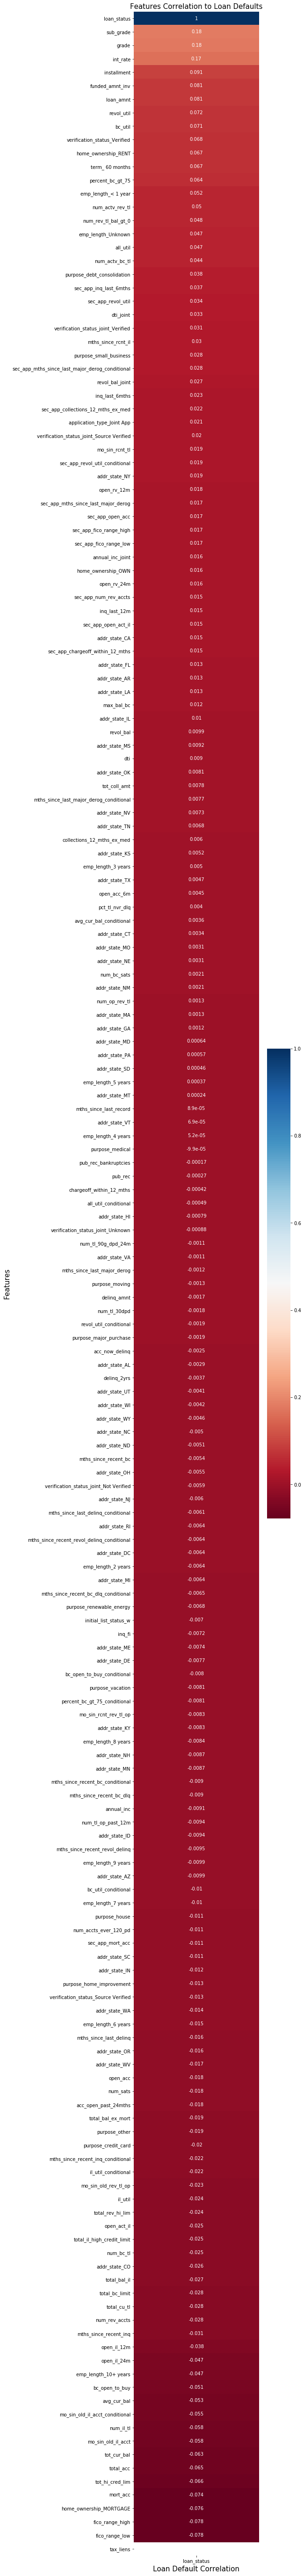

In [81]:
# Checking correlation all the features
plt.figure(figsize = (6,100))

top_correlations = df.corr()[['loan_status']].sort_values(by = 'loan_status', ascending = False)
sns.heatmap(top_correlations, annot = True, cmap = 'RdBu') 
plt.title('Features Correlation to Loan Defaults', fontsize = 15)
plt.xlabel('Loan Default Correlation', fontsize = 15)
plt.ylabel('Features', fontsize = 15);

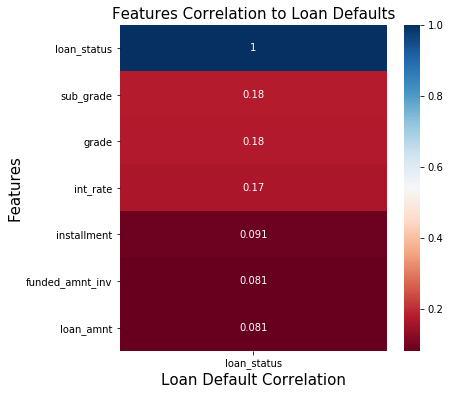

In [82]:
# Checking correlation all the features
plt.figure(figsize = (6,6))

top_correlations = df.corr()[['loan_status']].sort_values(by = 'loan_status', ascending = False)
sns.heatmap(top_correlations[top_correlations['loan_status']>0.08], annot = True, cmap = 'RdBu') 
plt.title('Features Correlation to Loan Defaults', fontsize = 15)
plt.xlabel('Loan Default Correlation', fontsize = 15)
plt.ylabel('Features', fontsize = 15);

In [83]:
df.describe()

,loan_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog_conditional,mths_since_recent_bc_dlq_conditional,mths_since_last_major_derog_conditional,mths_since_recent_revol_delinq_conditional,mths_since_last_delinq_conditional,il_util_conditional,mths_since_recent_inq_conditional,mo_sin_old_il_acct_conditional,bc_util_conditional,percent_bc_gt_75_conditional,bc_open_to_buy_conditional,mths_since_recent_bc_conditional,revol_util_conditional,all_util_conditional,avg_cur_bal_conditional,sec_app_revol_util_conditional,term_ 60 months,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_Unknown,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Unknown,verification_status_joint_Verified
count,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,4.417100e+04,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,4.417100e+04,44171.000000,44171.000000,44171.000000,4.417100e+04,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,4.417100e+04,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,4.417100e+04,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000

## 5. Preprocessing

Before we begin modeling, we need to identify our X features and Y target variables for our models. We need to split the data into training and testing set, in this thase we will use the default 80/20 split. Scaling the data is necessary because we have a large number of features with a variety of ranges. 

In [84]:
# create X and y
X = df.drop(columns = 'loan_status')
y = df['loan_status']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Scaling data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

Let's visualize how imbalanced our classes are

Number transactions before balancing X_train dataset:  (33128, 188)
Fully Paid: 29004
Defaulted: 4124


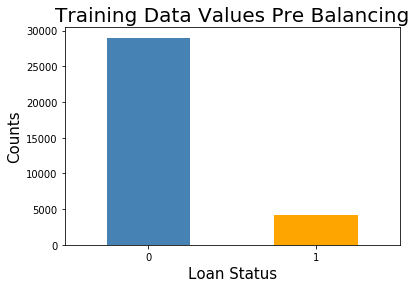

In [85]:
y_train_fully_paid = pd.Series(y_train).value_counts().sort_values(ascending = False)[0]
y_train_charged_off = pd.Series(y_train).value_counts().sort_values(ascending = False)[1]

# checking the new counts
print("Number transactions before balancing X_train dataset: ", X_train_sc.shape)
print(f'Fully Paid: {y_train_fully_paid}')
print(f'Defaulted: {y_train_charged_off}')

# observe that data has been balanced in training data
pd.Series(y_train).value_counts().sort_values(ascending = False).plot.bar(color = ['steelblue', 'orange'])
plt.title('Training Data Values Pre Balancing', size = 20)
plt.ylabel('Counts', size = 15)
plt.xlabel('Loan Status', size = 15, rotation = 0)
plt.xticks(rotation = 0);

Number transactions after balancing X_train dataset:  (58008, 188)


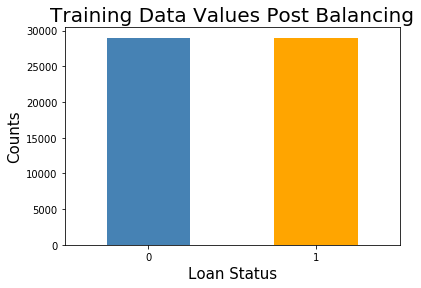

In [86]:
# instantiating SMOTE
sm = SMOTE(random_state = 42)
# fitting the scaled train data
X_train_new, y_train_new = sm.fit_sample(X_train_sc, y_train.ravel())

# checking the new counts
print("Number transactions after balancing X_train dataset: ", X_train_new.shape)

# observe that data has been balanced in training data
pd.Series(y_train_new).value_counts().sort_values(ascending = False).plot.bar(color = ['steelblue', 'orange'])
plt.title('Training Data Values Post Balancing', size = 20)
plt.ylabel('Counts', size = 15)
plt.xlabel('Loan Status', size = 15)
plt.xticks(rotation = 0);

## 6. Modeling

### 6.1 Baseline Model

A baseline Recall/Sensitivity score results in 0 when we are predicting all cases as the majority class, all borrowers fully pay back their loans. We will also aim to beat the baseline accuracy score of 87.55%.

In [87]:
# calcuating the baseline model for accuracy
1 - y_train.mean()

0.8755131610722048

### 6.2 Logistic Regression

Logistic regression results in a test recall score of 61.24% but at the cost of our accuracy, which was 67.12%. We would **NOT** recommend deploying this model, because nearly 9,000 favorable borrowers would be rejected only to save roughly 3670 unfavorable borrowers from being approved.

In [88]:
# Instantiate model for logistic regression, including max iterations
lr = LogisticRegression(random_state = 42, max_iter = 500)

# Fit model
lr.fit(X_train_new, y_train_new)

# checking accuracy scores
print(f'Logistic Regression Train Accuracy: {lr.score(X_train_new, y_train_new)}')
print(f'Logistic Regression Test Accuracy: {lr.score(X_test_sc, y_test)}')

# predicting values for linear regression
y_hat_lr_train = lr.predict(X_train_new)
y_hat_lr_test = lr.predict(X_test_sc)

# checking recall scores
lr_recall_train = recall_score(y_train_new, y_hat_lr_train)
lr_recall_test = recall_score(y_test, y_hat_lr_test)

print(f'Logistic Regression Train Recall: {lr_recall_train}')
print(f'Logistic Regression Test Recall: {lr_recall_test}')

Logistic Regression Train Accuracy: 0.6909047027996138
Logistic Regression Test Accuracy: 0.6711944218056688
Logistic Regression Train Recall: 0.7062474141497724
Logistic Regression Test Recall: 0.6123636363636363


In [89]:
# creating a function to run models and print Train and Test accuracy and recall scores for all other models
def run_model(model_name):
    # instantiating the model
    model = model_name(random_state = 42)
    # Fit model
    model.fit(X_train_new, y_train_new)
    
    # checking accuracy scores
    print(f'{model_name} Train Accuracy: {model.score(X_train_new, y_train_new)}')
    print(f'{model_name} Test Accuracy: {model.score(X_test_sc, y_test)}')

    # predicting values for linear regression
    y_hat_train = model.predict(X_train_new)
    y_hat_test = model.predict(X_test_sc)

    # checking recall scores
    recall_train = recall_score(y_train_new, y_hat_train)
    recall_test = recall_score(y_test, y_hat_test)

    print(f'{model_name} Train Recall: {recall_train}')
    print(f'{model_name} Test Recall: {recall_test}')

### 6.3 Random Forest Classifier

Random forest classifier results in a low testing recall score of 2.18%, but maintains a relatively high testing accuracy score of 87.53%.

In [90]:
run_model(RandomForestClassifier)

<class 'sklearn.ensemble._forest.RandomForestClassifier'> Train Accuracy: 1.0
<class 'sklearn.ensemble._forest.RandomForestClassifier'> Test Accuracy: 0.8753056234718827
<class 'sklearn.ensemble._forest.RandomForestClassifier'> Train Recall: 1.0
<class 'sklearn.ensemble._forest.RandomForestClassifier'> Test Recall: 0.02181818181818182


### 6.4 Extra Trees Classifier

Extra Trees also performed poorly in recall score of 2.25% and testing accuracy score of 87.39%

In [91]:
run_model(ExtraTreesClassifier)

<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> Train Accuracy: 1.0
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> Test Accuracy: 0.8744000724440822
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> Train Recall: 1.0
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> Test Recall: 0.02690909090909091


### 6.5 AdaBoost Classifier

Adaboost test recall score performs slightly better than random forest and extra trees at 7.27%, but reduces accuracy to 86.53%.

In [92]:
run_model(AdaBoostClassifier)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> Train Accuracy: 0.9109950351675631
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> Test Accuracy: 0.865344562166078
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> Train Recall: 0.8436422562405186
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> Test Recall: 0.07272727272727272


### 6.6 Gradient Boosting Classifier

Gradient Boosting is our most accurate model, but does not outperform the baseline accuracy. By extrapolating the test results to the actual 2019 results, we would have identified 80 unfavorable applicants at the cost of 101 favorable applicants. 

In [93]:
run_model(GradientBoostingClassifier)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> Train Accuracy: 0.9276479106330161
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> Test Accuracy: 0.8750339581635426
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> Train Recall: 0.8576058474693146
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> Test Recall: 0.014545454545454545


### 6.7 Confusion Matrix on most Accuract Classfier, Random Forest

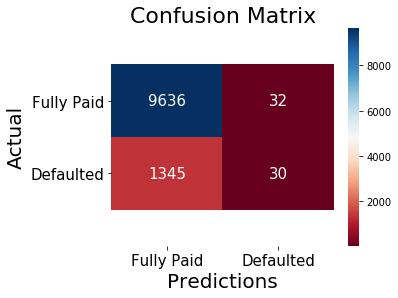

In [94]:
# Instantiate model for logistic regression, including max iterations
rf = RandomForestClassifier(random_state = 42)

# Fit model
rf.fit(X_train_new, y_train_new)

# predicting values for linear regression
y_hat_train = rf.predict(X_train_new)
y_hat_test = rf.predict(X_test_sc)

confm = confusion_matrix(y_test, y_hat_test)
columns = ['Fully Paid', 'Defaulted'] # need to fix this
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
# sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.figure(figsize = (5, 4))
plt.title('Confusion Matrix', size = 22)
sns.heatmap(df_cm, annot=True, fmt = 'd', annot_kws={"size": 15}, cmap = 'RdBu')
plt.ylabel('Actual', size = 20)
plt.xlabel('Predictions', size = 20)
plt.yticks(rotation = 0, size = 15)
plt.xticks(size = 15)

# shoutout to SalMac86 on https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [96]:
features = X.columns
importances = rf.feature_importances_
feature_importances = pd.DataFrame({
    'feature':features,
    'importances': np.round(importances, 2)
})

In [97]:
feature_importances.sort_values(by = 'importances', ascending = False).head(20)

,feature,importances
4,grade,0.06
2,int_rate,0.03
123,purpose_debt_consolidation,0.03
5,sub_grade,0.03
105,term_ 60 months,0.03
120,verification_status_Source Verified,0.03
119,home_ownership_RENT,0.03
28,open_il_12m,0.02
117,home_ownership_MORTGAGE,0.02
38,inq_fi,0.02


## 7. Conclusions and Evaluation

It seems after years of analyzing their data, Lending Club has a good handle on predicting the likelihood of default based on the data retreived on borrowers. They have steadily decreased loan default rates based on historical data from roughly 20% in 2016 to 12% in 2019. The modeling techniques we deployed thus far are unable to both correctly predict loans that will default that Lending Club missed, and at the same time outperform the current accuracy rate of 87.55%. Our most accurate model, Gradient Boosting Classifier, attained a testing accuracy score of 87.5% and recall of 1.45%, which represents 80 unfavorable applicants at the expense of 101 favorable applicants based on our original dataset. Lenders would need to decide if that is tradeoff they are willing to make. Will the interest earned on the 101 loans make up for the losses resulting from those 80 defaulted loans? Some of the issues that we encountered were the time and computation required to run these models. We also tested other classification models that took too long for our machines. There are also outside factors beyond the scope of the data received during a loan application that can explain why certain borrows default on their loans. One feature that we cannot accurately collect data on that would surely assist with model performance would be applicant's assets. Not all borrowers apply for loans because they do not have the money, some simply want to maintain a healthy emergency cash account. Certainly individuals with higher cash balances would have a higher ability to pay off loans compared to those with lower emergency savings. Some people also have sporadic income, which does not exist as an indicator in our model, but may depend on their employment titles, but there were over 30,000 titles in our dataset. With more time, we can certainly clean up this data to consolidate similar titles, or create groups that perhaps may provide additional insight. There are also unpredictable world events that may cause economic crisis, such as the current COVID-19 pandemic that has sent the travel industry plunging.